<a href="https://colab.research.google.com/github/cassiecinzori/ECON3916/blob/main/Assignments/ECON3916_AssignmentOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECON 3916 - Assignment One
### Cassandra Cinzori

## Phase One

##### Construct the "Student Basket"

In [63]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Gallon of Milk', 'Price_2016': 3.20, 'Price_2024': 4.02}]

##### Compute Inflation (Loops & Functions)

In [64]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Gallon of Milk: 25.62% Inflation


## Phase Two

##### The "Data Proxy" Strategy

In [65]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='6d181afd91d74ebf1bca70f8e0eea5d8')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
food_away = fred.get_series('CUSR0000SEFV')
streaming = fred.get_series('CUSR0000SERA02')
other = fred.get_series('APU0000709112')


##### Normalization Logic (CRITICAL)

In [66]:
import pandas as pd
df = pd.DataFrame({
    'CPI': official_cpi,
    'Tuition': tuition,
    'Rent': rent,
    'Food Away From Home': food_away,  # food away from home (Chipotle, Coffee, DoorDash etc.)
    'Streaming': streaming,
    'Groceries/Necessities': other  # groceries and other necessities
})

base_year = 2016

df = df[df.index.year >= base_year]


def reindex_to_base(series, base_year):
    base_value = series[series.index.year == base_year].iloc[0]

    return (series / base_value) * 100


df_reindexed = df.apply(lambda col: reindex_to_base(col, base_year))

# Step 5: Verify the transformation
print("First few rows (should show ~100 for 2016):")
print(df_reindexed.head())

print("\nBase year (2016) values:")
print(df_reindexed[df_reindexed.index.year == base_year].head())


First few rows (should show ~100 for 2016):
                   CPI     Tuition        Rent  Food Away From Home  \
2016-01-01  100.000000  100.000000  100.000000           100.000000   
2016-02-01   99.867032  100.241572  100.314364           100.138869   
2016-03-01  100.180095  100.470288  100.607131           100.355827   
2016-04-01  100.563850  100.692146  100.924580           100.599712   
2016-05-01  100.801592  100.929861  101.258485           100.813978   

             Streaming  Groceries/Necessities  
2016-01-01  100.000000             100.000000  
2016-02-01  100.723912              97.494718  
2016-03-01  101.450163              96.196800  
2016-04-01  101.878663              95.230909  
2016-05-01  102.214306              95.291277  

Base year (2016) values:
                   CPI     Tuition        Rent  Food Away From Home  \
2016-01-01  100.000000  100.000000  100.000000           100.000000   
2016-02-01   99.867032  100.241572  100.314364           100.138869   
20

## Phase Three

##### Visualizing Raw Components

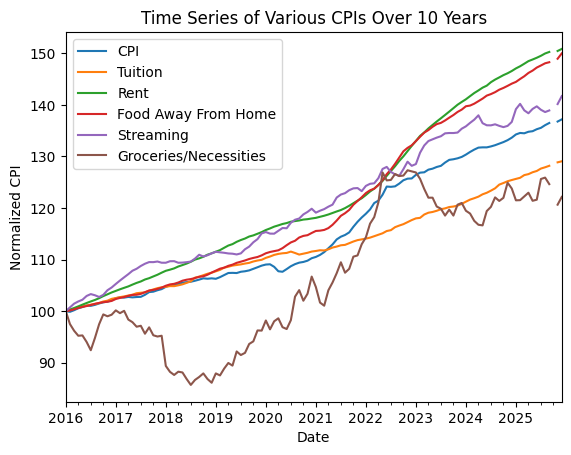

In [67]:
import matplotlib.pyplot as plt

df_reindexed.plot(title='Time Series of Various CPIs Over 10 Years')
plt.ylabel('Normalized CPI')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()



##### The Weighted "Student SPI" (Honest Chart)


In [68]:
# Set weights
student_weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Food Away From Home': 0.05,
    'Streaming': 0.1,
    'Groceries/Necessities': 0.15
}

print(f"Total weight: {sum(student_weights.values())}") # Weight should = 1

Total weight: 1.0


In [69]:
# Normalize each series to base_year = 100
df['CPI_Index'] = (df['CPI'] / df.loc[df.index.year == base_year, 'CPI'].iloc[0]) * 100
df['Tuition_Index'] = (df['Tuition'] / df.loc[df.index.year == base_year, 'Tuition'].iloc[0]) * 100
df['Rent_Index'] = (df['Rent'] / df.loc[df.index.year == base_year, 'Rent'].iloc[0]) * 100
df['Food_Index'] = (df['Food Away From Home'] / df.loc[df.index.year == base_year, 'Food Away From Home'].iloc[0]) * 100
df['Streaming_Index'] = (df['Streaming'] / df.loc[df.index.year == base_year, 'Streaming'].iloc[0]) * 100
df['Groceries_Index'] = (df['Groceries/Necessities'] / df.loc[df.index.year == base_year, 'Groceries/Necessities'].iloc[0]) * 100

# Check the normalized values
print(df[['CPI_Index', 'Tuition_Index', 'Rent_Index']].head())

             CPI_Index  Tuition_Index  Rent_Index
2016-01-01  100.000000     100.000000  100.000000
2016-02-01   99.867032     100.241572  100.314364
2016-03-01  100.180095     100.470288  100.607131
2016-04-01  100.563850     100.692146  100.924580
2016-05-01  100.801592     100.929861  101.258485


In [70]:
# Calculate Student Weighted Sum
df['Student_SPI'] = (
    student_weights['Tuition'] * df['Tuition_Index'] +
    student_weights['Rent'] * df['Rent_Index'] +
    student_weights['Food Away From Home'] * df['Food_Index'] +
    student_weights['Streaming'] * df['Streaming_Index'] +
    student_weights['Groceries/Necessities'] * df['Groceries_Index']
)

df[['CPI_Index', 'Student_SPI']].head()

,CPI_Index,Student_SPI
2016-01-01,100.000000,100.000000
2016-02-01,99.867032,99.894481
2016-03-01,100.180095,99.962582
2016-04-01,100.563850,100.056721
2016-05-01,100.801592,100.305311


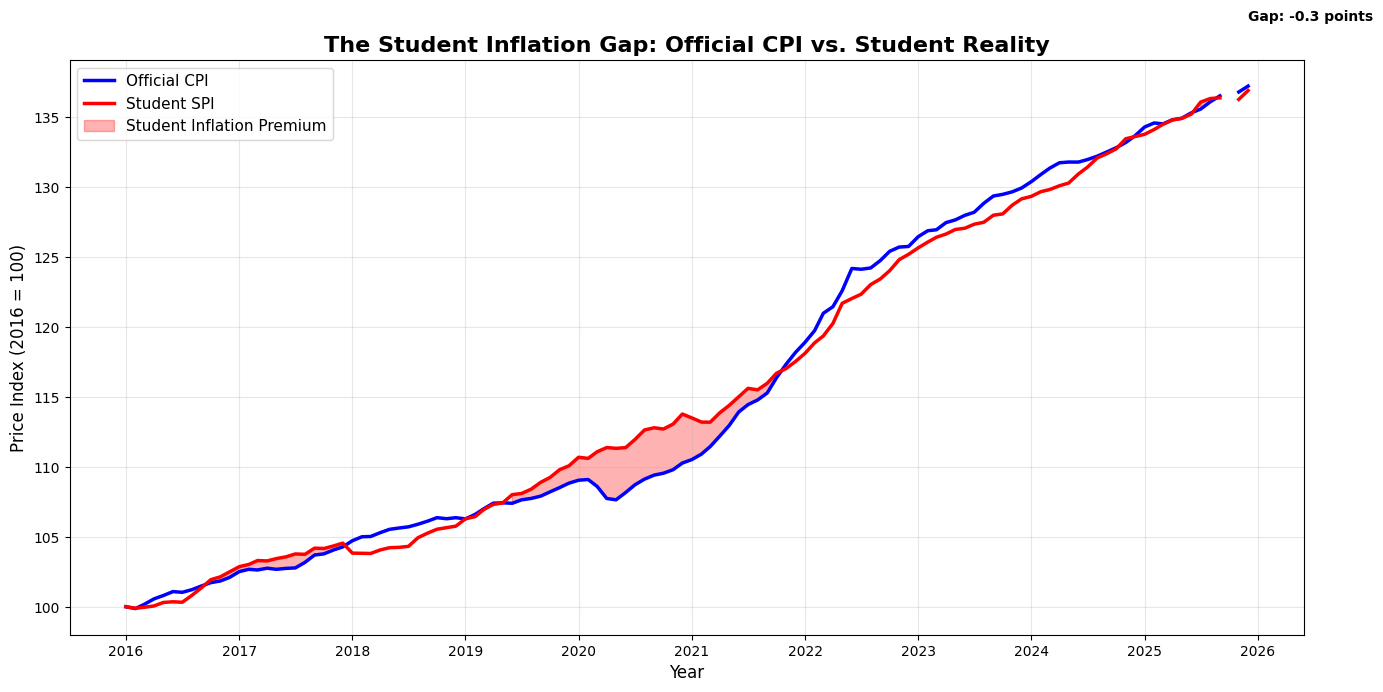

In [71]:
# Plot Student Inflation Gap
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both indices
ax.plot(df.index, df['CPI_Index'], label='Official CPI', color='blue', linewidth=2.5)
ax.plot(df.index, df['Student_SPI'], label='Student SPI', color='red', linewidth=2.5)

# Inflation gap
ax.fill_between(df.index, df['CPI_Index'], df['Student_SPI'],
                where=(df['Student_SPI'] >= df['CPI_Index']),
                color='red', alpha=0.3, label='Student Inflation Premium')

# Titles/customizations
ax.set_title('The Student Inflation Gap: Official CPI vs. Student Reality',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Price Index (2016 = 100)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation showing the gap
latest_gap = df['Student_SPI'].iloc[-1] - df['CPI_Index'].iloc[-1]
ax.annotate(f'Gap: {latest_gap:.1f} points',
            xy=(df.index[-1], df['Student_SPI'].iloc[-1]),
            xytext=(df.index[-1], df['Student_SPI'].iloc[-1] + 5),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [72]:
# Interpreting and Calculating The Student Inflation Gap

# Calculate the cumulative difference
latest_date = df.index[-1]
gap = df['Student_SPI'].iloc[-1] - df['CPI_Index'].iloc[-1]

print(f"\n{'='*60}")
print(f"STUDENT INFLATION GAP ANALYSIS")
print(f"{'='*60}")
print(f"Base Year: {base_year}")
print(f"Latest Data: {latest_date.strftime('%Y-%m')}")
print(f"\nOfficial CPI Index: {df['CPI_Index'].iloc[-1]:.2f}")
print(f"Student SPI Index: {df['Student_SPI'].iloc[-1]:.2f}")
print(f"\nInflation Gap: {gap:.2f} points")
print(f"\nInterpretation: Student costs have risen {gap:.2f}% MORE")
print(f"than official inflation suggests since {base_year}.")
print(f"{'='*60}\n")


STUDENT INFLATION GAP ANALYSIS
Base Year: 2016
Latest Data: 2025-12

Official CPI Index: 137.19
Student SPI Index: 136.87

Inflation Gap: -0.32 points

Interpretation: Student costs have risen -0.32% MORE
than official inflation suggests since 2016.



##### The Scale Fallacy (Why We Normalize)


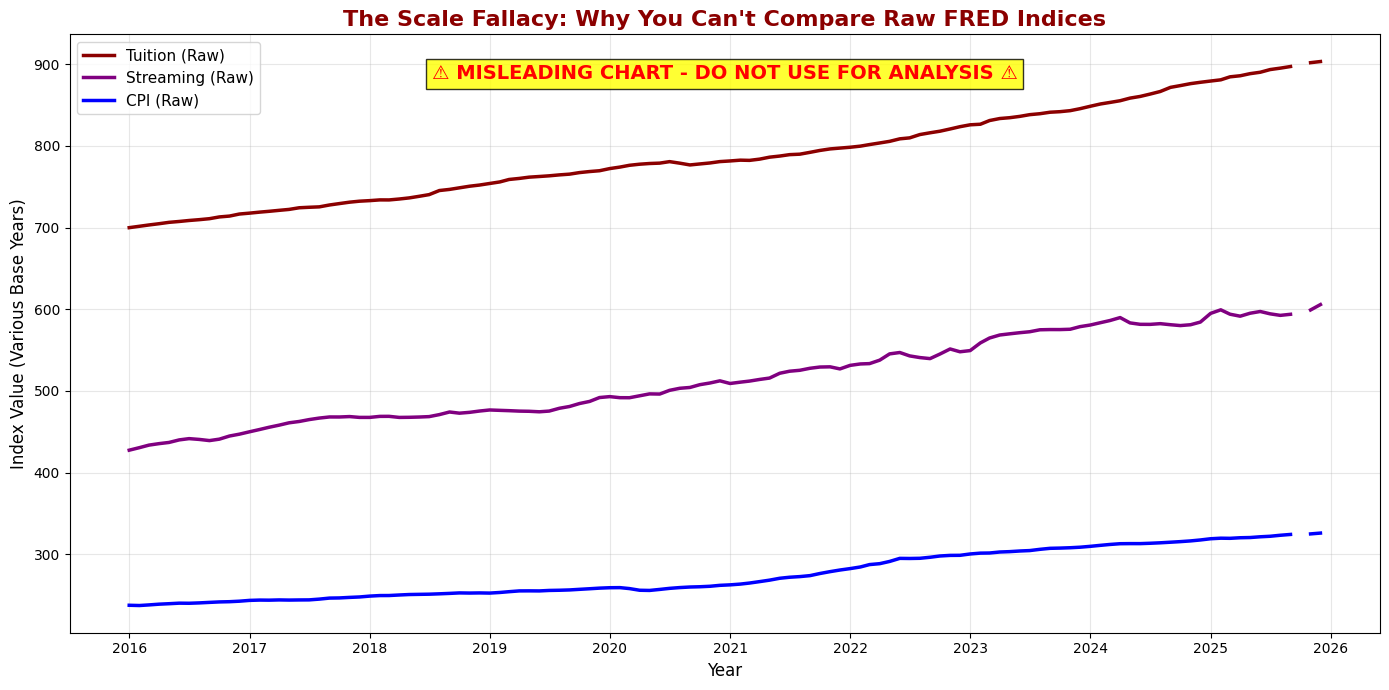


RAW INDEX VALUES (Latest Month)
Tuition:   903.40
Streaming: 605.83
CPI:       326.03

Tuition appears 1.5x larger than Streaming
But this comparison is meaningless due to different base years.



In [73]:
# Plot RAW data (no normalization - "Bad Graph")
fig, ax = plt.subplots(figsize=(14, 7))

# Plot raw values
ax.plot(df.index, df['Tuition'], label='Tuition (Raw)', color='darkred', linewidth=2.5)
ax.plot(df.index, df['Streaming'], label='Streaming (Raw)', color='purple', linewidth=2.5)
ax.plot(df.index, df['CPI'], label='CPI (Raw)', color='blue', linewidth=2.5)

# Titles/customziation
ax.set_title('The Scale Fallacy: Why You Can\'t Compare Raw FRED Indices',
             fontsize=16, fontweight='bold', color='darkred')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index Value (Various Base Years)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Add a warning annotation
ax.text(0.5, 0.95, '⚠️ MISLEADING CHART - DO NOT USE FOR ANALYSIS ⚠️',
        transform=ax.transAxes, fontsize=14, color='red',
        weight='bold', ha='center', va='top',
        bbox=dict(facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Print the actual values to show the scale difference
print("\n" + "="*60)
print("RAW INDEX VALUES (Latest Month)")
print("="*60)
print(f"Tuition:   {df['Tuition'].iloc[-1]:.2f}")
print(f"Streaming: {df['Streaming'].iloc[-1]:.2f}")
print(f"CPI:       {df['CPI'].iloc[-1]:.2f}")
print(f"\nTuition appears {df['Tuition'].iloc[-1] / df['Streaming'].iloc[-1]:.1f}x larger than Streaming")
print("But this comparison is meaningless due to different base years.")
print("="*60 + "\n")

### The Scale Fallacy: Why We Normalize

#### The "Data Crime"

In the chart above, Tuition appears ~700+ while Streaming is ~400+. This would mean that tuition is 1.75% more expensive, which is not true.

---

#### Why This Is Misleading

Each FRED index has a different base year:

| Index | Base Year |
|-------|-----------|
| **CPI & Tuition** | 1982-1984 = 100 |
| **Streaming** | December 1997 = 100 |

When Tuition was set to 100 (1982-1984), streaming didn't exist. When streaming becaome a product at 100 (1997), tuition had already grown for 15 years.

---

#### What Raw Numbers Actually Mean

- Tuition = 700 → 7x more expensive than 1982-1984
- Streaming = 400 → 4x more expensive than December 1997

You cannot compare these two since they are describing different time periods.

---

#### The Fix: Normalization

Normalizing to the same base year (2016 = 100) puts everyone at the same starting line, so that we can make valid comparisons

Example: If the tuition index = 120 and streaming index = 105 (both with the base year being 2016), we can say that since 2016, tuition grew 20% while streaming grew 5%.

---

#### Bottom Line

Comparing raw FRED indices with different base years isn't statistically correct. Without normalization, you'd miscalculate your Student SPI and mislead everyone.

## Phase Four

##### The Ultimate Reality Check (Boston vs. USA vs. You)

Fetching Boston CPI data from FRED...


/tmp/ipython-input-2906828186.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Boston_CPI_Raw'] = df['Boston_CPI_Raw'].fillna(method='ffill')


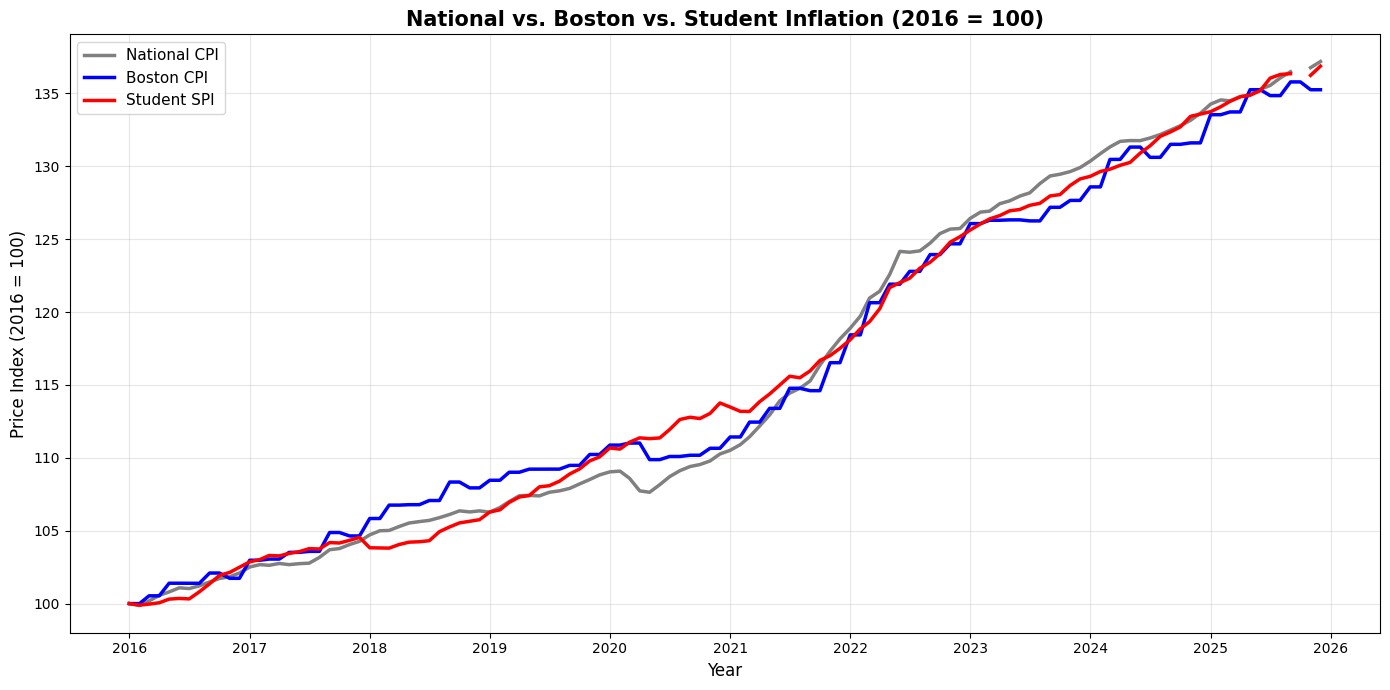


VERIFICATION:
Jan 2016 - National CPI:  100.00
Jan 2016 - Boston CPI:    100.00
Jan 2016 - Student SPI:   100.00


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Initialize FRED API
fred = Fred(api_key='6d181afd91d74ebf1bca70f8e0eea5d8')


# FETCH BOSTON CPI DATA

# FRED Series ID: CUURA103SA0
# Consumer Price Index for All Urban Consumers: All Items in Boston-Cambridge-Newton, MA-NH
print("Fetching Boston CPI data from FRED...")
boston_cpi_raw = fred.get_series('CUURA103SA0')

# Convert to DataFrame
boston_df = pd.DataFrame({'Boston_CPI_Raw': boston_cpi_raw})

# Merge with existing DataFrame
df = df.join(boston_df, how='left')

# Handle missing values (forward-fill if any gaps)
df['Boston_CPI_Raw'] = df['Boston_CPI_Raw'].fillna(method='ffill')


# NORMALIZE BOSTON CPI TO JAN 1, 2016 = 100

base_year = 2016

# Get January 2016 baseline value
base_value_boston = df.loc[df.index.year == base_year, 'Boston_CPI_Raw'].iloc[0]

# Normalize to 100
df['Boston_CPI'] = (df['Boston_CPI_Raw'] / base_value_boston) * 100


# PLOT THREE LINES

fig, ax = plt.subplots(figsize=(14, 7))

# Plot National CPI (Grey)
ax.plot(df.index, df['CPI_Index'],
        label='National CPI',
        color='grey',
        linewidth=2.5)

# Plot Boston CPI (Blue)
ax.plot(df.index, df['Boston_CPI'],
        label='Boston CPI',
        color='blue',
        linewidth=2.5)

# Plot Student SPI (Red)
ax.plot(df.index, df['Student_SPI'],
        label='Student SPI',
        color='red',
        linewidth=2.5)

# Styling
ax.set_title('National vs. Boston vs. Student Inflation (2016 = 100)',
             fontsize=15, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Price Index (2016 = 100)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Verify normalization
print("\n" + "="*60)
print("VERIFICATION:")
print("="*60)
print(f"Jan 2016 - National CPI:  {df.loc[df.index.year == 2016, 'CPI_Index'].iloc[0]:.2f}")
print(f"Jan 2016 - Boston CPI:    {df.loc[df.index.year == 2016, 'Boston_CPI'].iloc[0]:.2f}")
print(f"Jan 2016 - Student SPI:   {df.loc[df.index.year == 2016, 'Student_SPI'].iloc[0]:.2f}")
print("="*60)

#### Summary Stats

In [75]:
# 1. Student inflation premium
student_gap = df['Student_SPI'].iloc[-1] - df['CPI_Index'].iloc[-1]
print(f"Student costs divergence: {student_gap:.1f}%")

# 2. Boston regional premium
boston_gap = df['Boston_CPI'].iloc[-1] - df['CPI_Index'].iloc[-1]
print(f"Boston regional premium: {boston_gap:.1f}%")

# 3. Total compounded effect
total_gap = df['Student_SPI'].iloc[-1] - df['CPI_Index'].iloc[-1]
print(f"Total student disadvantage: {total_gap:.1f}%")

# 4. Cumulative inflation since 2016
national_inflation = df['CPI_Index'].iloc[-1] - 100
student_inflation = df['Student_SPI'].iloc[-1] - 100
print(f"National inflation since 2016: {national_inflation:.1f}%")
print(f"Student inflation since 2016: {student_inflation:.1f}%")

# 5. Weights used in Student SPI
print("Student spending weights:")
for category, weight in student_weights.items():
    print(f"  {category}: {weight*100:.0f}%")

Student costs divergence: -0.3%
Boston regional premium: -1.9%
Total student disadvantage: -0.3%
National inflation since 2016: 37.2%
Student inflation since 2016: 36.9%
Student spending weights:
  Tuition: 40%
  Rent: 30%
  Food Away From Home: 5%
  Streaming: 10%
  Groceries/Necessities: 15%
